# Machine learning applied to hyperspectral images <a id="top-notebook"></a>

**Authors**:
* louis.guo
* raphael.ramelet
* ilan.guenet

**Table of content**:
* [Load data](#load-data)
* [Preprocessing](#preprocessing)
    * [Standard Scaler](#standard-scaler)
    * [Dimension reduction (PCA)](#dimension-reduction)
    * [SelectKBest](#selectkbest)
* [Classification API](#classification-api)
    * [Grid search with cross-validation](#grid-search)
    * [Evaluation](#api-evaluation)
* [Multiclass classification](#multiclass-classification)
    * [With other VS without other](#with-vs-without)
        * [LinearSVC](#linear-svc-1)
        * [RandomForest](#random_forest-1)
    * [Bench classifiers](#bench-classifier)
        * [LinearSVC (One Versus All)](#linear-svc-2)
        * [RandomForest (Inherently multiclass)](#random_forest-2)
        * [K-nearest neighbors (Inherently multiclass)](#k-nearest-2)
        * [SVC (One Versus One)](#svc-2)
    * [Two consecutive classifiers](#two-consecutive-classifiers)
* [Evaluate best classifier](#evaluate-best-classifier)

Import python depedencies. Remember to run ```pip install -r requirements.txt``` before running the notebook

In [1]:
# !pip install -r requirements

# If using pip3
# !pip3 install -r requirements.txt

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import seaborn as sn

# Save models
from joblib import dump, load

%matplotlib inline

# Pretty pretting of sklearn classifiers
sk.set_config(display='diagram')

random_state = 2727

## Load data <a id="load-data"></a>
[Table of content](#top-notebook)

### Hyperspectral image

In [3]:
!ls data/

indianapines_gt.npy  indianapines.npy  salinas_gt.npy  salinas.npy


In [4]:
X_indiana = np.load("data/indianapines.npy").astype('float32')
X_indiana.shape, X_indiana.dtype, np.min(X_indiana), np.max(X_indiana)

((145, 145, 200), dtype('float32'), 955.0, 9604.0)

In [5]:
X_salinas = np.load("data/salinas.npy").astype('float32')
X_salinas.shape, X_salinas.dtype, np.min(X_salinas), np.max(X_salinas)

((512, 217, 204), dtype('float32'), -11.0, 9207.0)

In [6]:
def plot_rgb(im, title):
    """
    Plot a hyperspectral image as an RGB image
    
    Parameters
    ----------
    im : numpy.ndarray
        The hyperspectral image as a ndarray.
    title: str
        Title of the image
    """
    rgb_bands = np.array([30, 15, 2])
    im_rgb = im[:,:,rgb_bands]

    pmin, pmax = np.percentile(im_rgb, (1,99), axis=(0,1))
    
    for i in range(pmin.size):
        # Normalize
        im_rgb[:,:,i] = (im_rgb[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])
        
    im_rgb[im_rgb<0] = 0
    im_rgb[im_rgb>1] = 1
    plt.axis("off")
    plt.title(title)
    plt.imshow(im_rgb)
    plt.plot()

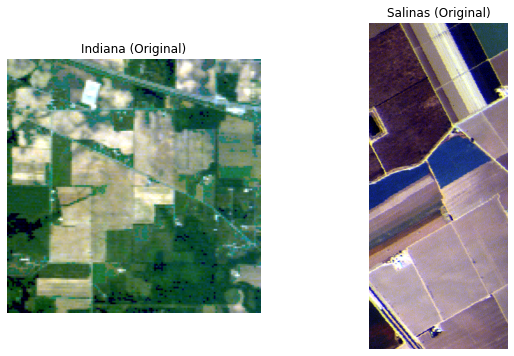

In [7]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plot_rgb(X_indiana, "Indiana (Original)")
plt.subplot(122)
plot_rgb(X_salinas, "Salinas (Original)")
plt.show()

The two hyperspectral images look **different**:
* **Their shape** is different. The indiana image has a shape of (145, 145) and the salinas image has a shape of (512, 217). The salinas image has five times more pixels than the indiana image.
* **The number of bandwith** is different. The indiana image has 200 bandwidths. On the other hand, the salinas image has 204 bandwidths. When the hyperspectral image is acquired, some of the bandwidths may be corrupted. Those corrputed bandwidths are not saved. It explains the difference of number of bandwidth between the two hyperspectral images. The salinas image has less corrupted bandwidths. 
* As the two hyperspectral images were taken in **two different sites**, the objects on the ground are different. It can be seen with the difference of color. The indiana image look more green and the salinas image look more blue.
    
Luckily, the **data type** is the same (float32).

### Load labels

In [8]:
y_indiana = np.load("data/indianapines_gt.npy")
y_indiana.shape, y_indiana.dtype, np.min(y_indiana), np.max(y_indiana)

((145, 145), dtype('uint8'), 0, 16)

In [9]:
y_salinas = np.load("data/salinas_gt.npy")
y_salinas.shape, y_salinas.dtype, np.min(y_salinas), np.max(y_salinas)

((512, 217), dtype('uint8'), 0, 16)

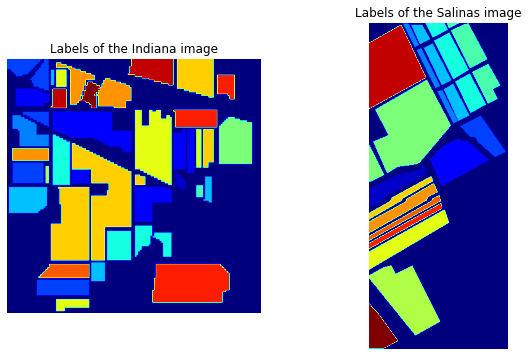

In [10]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.imshow(y_indiana, cmap='jet')
plt.title("Labels of the Indiana image")
plt.axis("off")


plt.subplot(122)
plt.imshow(y_salinas, cmap='jet')
plt.title("Labels of the Salinas image")
plt.axis("off")

plt.show()

Every images has 17 categories. Category 0 is considered as a non-category. This category is going to be called `Other` from now on. Also, the other category seems to be the main category which means many pixels are actually not labelled.

Even if the two images has the same number of categories, the categories between the two images are not related.

### Dictionary label to category

<table>
    <tr><th>Categories from Indiana</th>
        <th>Categories from Salinas</th>
    </tr>
    <tr><td>
    
| # | Category name |
|---|-------|
| 0 | Other |
| 1 | Alfalfa |
| 2 | Corn-notill |
| 3 | Corn-mintill |
| 4 | Corn |
| 5 | Grass-pasture |
| 6 | Grass-trees |
| 7 | Grass-pasture-mowed |
| 8 | Hay-windrowed |
| 9 | Oats |
| 10 | Soybean-notill |
| 11 | Soybean-mintill |
| 12 | Soybean-clean |
| 13 | Wheat |
| 14 | Woods |
| 15 | Buildings-Grass-Trees-Drives |
| 16 | Stone-Steel-Towers |
    
</td><td>
    
| # | Category name |
|---|-------|
| 0 | Other |
| 1 | Brocoli_green_weeds_1 |
| 2 | Brocoli_green_weeds_2 |
| 3 | Fallow |
| 4 | Fallow_rough_plow |
| 5 | Fallow_smooth |
| 6 | Stubble |
| 7 | Celery |
| 8 | Grapes_untrained |
| 9 | Soil_vinyard_develop |
| 10 | Corn_senesced_green_weeds |
| 11 | Lettuce_romaine_4wk |
| 12 | Lettuce_romaine_5wk |
| 13 | Lettuce_romaine_6wk |
| 14 | Lettuce_romaine_7wk |
| 15 | Vinyard_untrained |
| 16 | Vinyard_vertical_trellis |
    
</td></tr>
</table>

In [11]:
label_to_category = dict()

label_to_category['indiana'] = {  0: "Other",
                                  1: "Alfalfa",
                                  2: "Corn-notill",
                                  3: "Corn-mintill",
                                  4: "Corn",
                                  5: "Grass-pasture",
                                  6: "Grass-trees",
                                  7: "Grass-pasture-mowed",
                                  8: "Hay-windrowed",
                                  9: "Oats",
                                 10: "Soybean-notill",
                                 11: "Soybean-mintill",
                                 12: "Soybean-clean",
                                 13: "Wheat",
                                 14: "Woods",
                                 15: "Buildings-Grass-Trees-Drives",
                                 16: "Stone-Steel-Towers"}

label_to_category['salinas'] = { 0: 'Other',
                                 1: 'Brocoli_green_weeds_1',
                                 2: 'Brocoli_green_weeds_2',
                                 3: 'Fallow',
                                 4: 'Fallow_rough_plow',
                                 5: 'Fallow_smooth',
                                 6: 'Stubble',
                                 7: 'Celery',
                                 8: 'Grapes_untrained',
                                 9: 'Soil_vinyard_develop',
                                10: 'Corn_senesced_green_weeds',
                                11: 'Lettuce_romaine_4wk',
                                12: 'Lettuce_romaine_5wk',
                                13: 'Lettuce_romaine_6wk',
                                14: 'Lettuce_romaine_7wk',
                                15: 'Vinyard_untrained',
                                16: 'Vinyard_vertical_trellis'}

len(label_to_category), len(label_to_category['indiana']), len(label_to_category['salinas'])

(2, 17, 17)

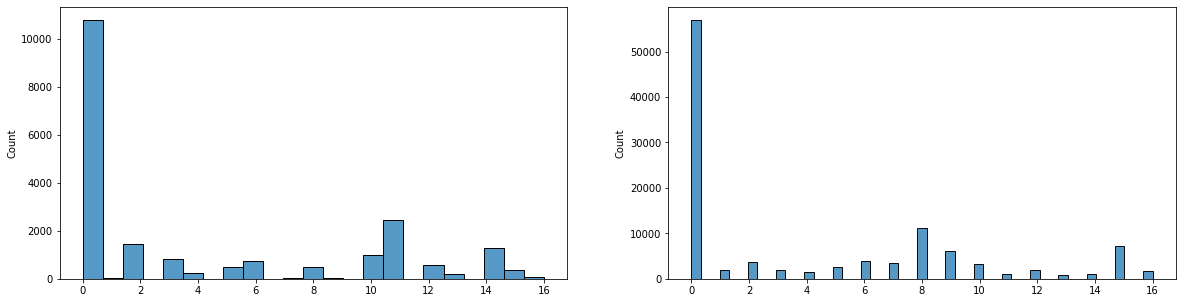

In [12]:
plt.figure(figsize=(20,5))

plt.subplot(121)
ax_indiana = sn.histplot(y_indiana.flatten())

plt.subplot(122)
ax_salinas = sn.histplot(y_salinas.flatten())

plt.show()

In the two hyperspectral images, the categories are strongly unbalanced and the dominant category is the Other category.

### Reshape inputs

In [13]:
# The classifiers requires a 2D matrix.
indiana_row, indiana_col, indiana_dim = X_indiana.shape
X_indiana = X_indiana.reshape((-1, indiana_dim))

y_indiana = y_indiana.flatten()
X_indiana.shape, y_indiana.shape

((21025, 200), (21025,))

In [14]:
# Same for salinas
salinas_row, salinas_col, salinas_dim = X_salinas.shape
X_salinas = X_salinas.reshape((-1, salinas_dim))

y_salinas = y_salinas.flatten()
X_salinas.shape, y_salinas.shape

((111104, 204), (111104,))

## Preprocessing <a id="preprocessing"></a>

[Table of content](#top-notebook)

### Standard scaler <a id="standard-scaler"></a>

[Table of content](#top-notebook)

Standardize the features by substracting the mean and dividing the variance such that:
$$ x_{new} = \frac{x - u}{s} $$

In machine learning, it is better to scale the data to look like a standard normal distributed data. According to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">scikit-learn</a>: `For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order`. Some algorithms assume the data are standardized. Thus, this is a must-do step.

<ipython-input-15-71ea6a74cf3e>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


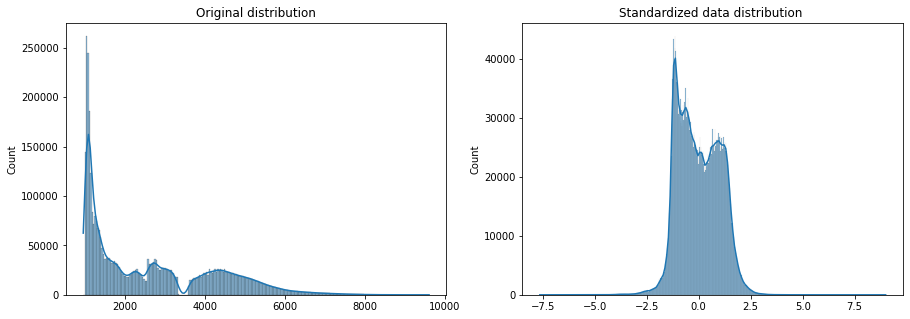

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Compute mean and variance
scaler.fit(X_indiana)

# Standardize data
scaled_indiana = scaler.transform(X_indiana)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sn.histplot(X_indiana.flatten(), ax=axes[0], kde=True)
axes[0].set_title("Original distribution")

sn.histplot(scaled_indiana.flatten(), ax=axes[1], kde=True)
axes[1].set_title("Standardized data distribution ")
fig.show()

### Dimension reduction (PCA)<a id="dimension-reduction"></a>

[Table of content](#top-notebook)

Machine learning is more efficient with lower dimensions. The hyperspectral image have at least 200 dimensions. That seems way too large for any machine learning algorithm. Thus, we are going to reduce the dimension of the problem using the **P**rincipal **C**omponents **A**nalysis (**PCA**) algorithm.

Documentation:
* <a href=https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>scikit-learn PCA</a>


#### Setup PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(random_state=random_state)
pca

PCA(random_state=2727)

In [17]:
pca.fit(X_indiana)

PCA(random_state=2727)

#### Analyse PCA

In [18]:
print(f"Number of components: {pca.n_components_} (equals to number of wavelength)")

Number of components: 200 (equals to number of wavelength)


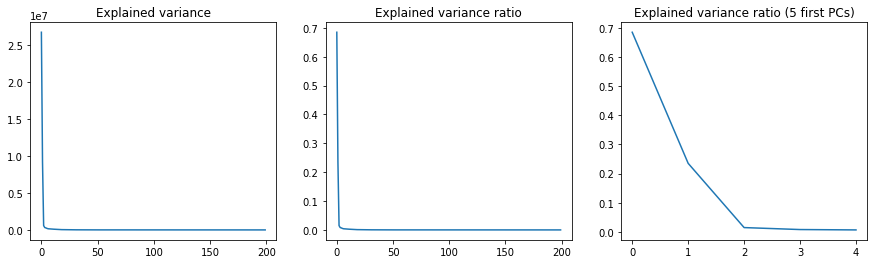

In [19]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(pca.explained_variance_)
plt.title("Explained variance")

plt.subplot(1, 3, 2)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio")

plt.subplot(1, 3, 3)
plt.plot(pca.explained_variance_ratio_[:5])
plt.title("Explained variance ratio (5 first PCs)")

plt.show()

In [20]:
print(f"The first component explains {np.floor(pca.explained_variance_ratio_[0] * 100)}% of the variance")
print(f"The second component explains {np.floor(pca.explained_variance_ratio_[1] * 100)}% of the variance")

The first component explains 68.0% of the variance
The second component explains 23.0% of the variance


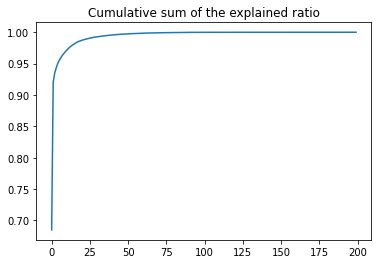

In [21]:
var_cumsum = pca.explained_variance_ratio_.cumsum()

plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

The first principal components explains most of the variance. It is not needed to keep the last principal components. They usually hold the information of noise. As we want to reduce the dimensions, only the first principal components are going to be used to project data into a new space.

#### Make decision

How many principal components are we going to use to project data? We want to project the data in a way that at least a percentage (threshold) of the variance (information) is preserved. This information can be found from the cumulative sum of the expained variance. We pick as many principal components until their total explained variance is greater than the threshold.

In [22]:
threshold = 0.95 # 95%

# Number of selected principal components such as the cumulative sum of the explained 
# variance ratio of these principal components is at least greater than the threshold 
nb_pc = np.where(var_cumsum>threshold)[0][0] + 1
print('%d principal components explains at least %1.2f%% of the \
variance.'%(nb_pc, threshold * 100))

5 principal components explains at least 95.00% of the variance.


In [23]:
pca_params = {"n_components" : nb_pc}
pca = pca.set_params(**pca_params)

# We need to fit again to use the new params 
pca.fit(X_indiana)

PCA(n_components=5, random_state=2727)

#### Projection

In [24]:
# Projection of the data into the new basis from the PCA
Xproj = pca.transform(X_indiana)
Xproj = Xproj.reshape((indiana_row, indiana_col, nb_pc))
Xproj.shape

(145, 145, 5)

The hyperspectral image is projected from 200 dimensions to the number of PC dimensions (5 if 95% is the threshold). Thus, the number of dimensions is strongly reduced.

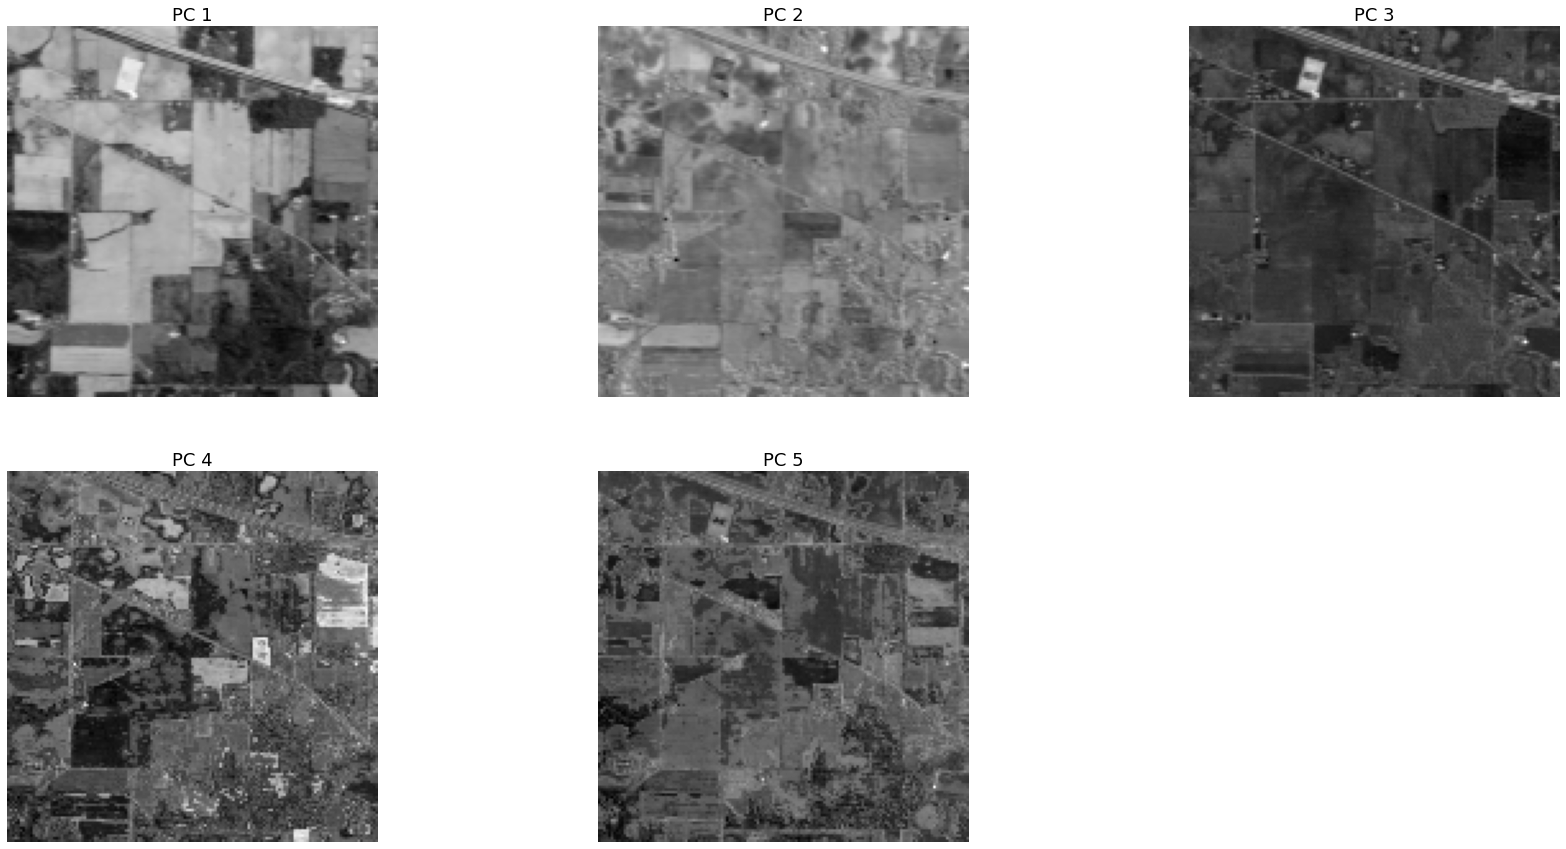

In [25]:
# Plot the information of each principal components

plt.figure(figsize=(30,15))
for i in range(nb_pc):
    plt.subplot(int(nb_pc / 3) + 1, 3, i+1)
    plt.title('PC %d'%(i+1), fontsize=18)
    plt.axis('off')
    plt.imshow(Xproj[:,:,i], cmap='gray')
plt.show()

In [26]:
Xproj_back = pca.inverse_transform(Xproj)
Xproj_back.shape # The shape is back to the original image

(145, 145, 200)

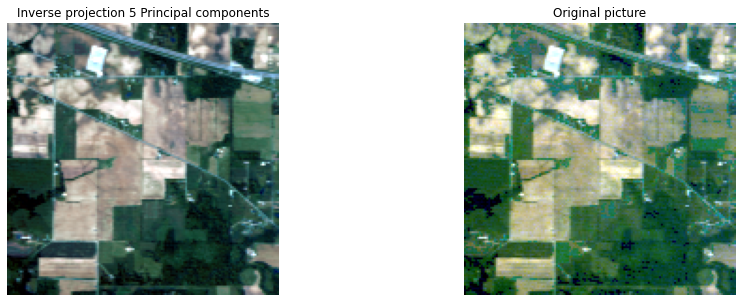

In [27]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plot_rgb(Xproj_back,
         "Inverse projection " + str(nb_pc) + " Principal components")

plt.subplot(1,2,2)
plot_rgb(X_indiana.reshape(indiana_row, indiana_col, indiana_dim),
         "Original picture")

plt.show()

#### Extra information

##### Mean Square Error (MSE)

In [28]:
def MSE(im1,im2):
    if im1.ndim > 2:
        im1 = im1.reshape((-1,im1.shape[2]))
    if im2.ndim > 2:
        im2 = im2.reshape((-1,im2.shape[2]))
    mse = ((im1-im2)**2).sum(axis=1).mean()
    return mse

MSE(Xproj_back, X_indiana)

1941170.2

In [29]:
# Create a range of number of principal components to use for each PCA
nb_pc_range = np.unique(np.round(np.geomspace(1, 190, num=20))).astype(int)
nb_pc_range

array([  1,   2,   3,   4,   5,   7,   9,  12,  16,  21,  27,  36,  48,
        63,  83, 109, 144, 190])

In [30]:
mse_seq = []
for nb_pc_curr in nb_pc_range:
    pca_mse = PCA(n_components = nb_pc_curr, random_state = random_state)
    
    # Fit and transform
    testproj = pca_mse.fit_transform(X_indiana)
    # Inverse transform
    testproj_back = pca_mse.inverse_transform(testproj)
    testproj_back = testproj_back.reshape((indiana_row, indiana_col, indiana_dim))
    # Compute MSE
    mse_seq.append(MSE(testproj_back, X_indiana))

mse_seq = np.array(mse_seq)

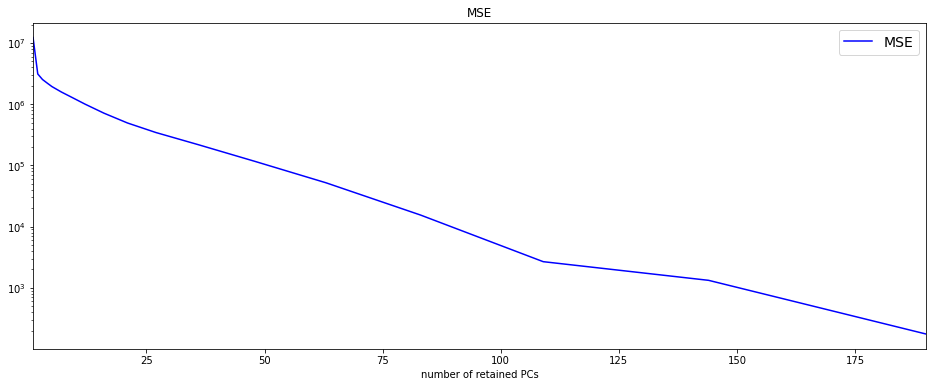

In [31]:
plt.figure(figsize=(16,6))

plt.plot(nb_pc_range, mse_seq, 'b', label='MSE')
plt.xlim(nb_pc_range[0], nb_pc_range[-1])
plt.xlabel('number of retained PCs')
plt.yscale('log')
plt.legend(loc='best', fontsize=14)
plt.title('MSE')
plt.show()

The MSE is lower when the number of retained PCs is greater. It means the error is lower with a greater number of PCs. However, with a few PCs the error might be already low enough.

#### Thresholds

Function to get the number of principal components to use according to a threshold of the explained variance. This function is needed during a grid search (later used in the notebook).

In [32]:
def get_pca_components(X, thresholds=[0.90, 0.95, 0.99]):
    """
    Get the number of components for each threshold
    
    Parameters
    ----------
    X: numpy.ndarray
        The input data
    thresholds: list
        List of thresholds
        
    Returns
    -------
    list
        List of number of components for each given threshold
    """

    pca = PCA(random_state=random_state)
    pca.fit(X)
    param_n_components = []
    for threshold in thresholds:
        var_cumsum = pca.explained_variance_ratio_.cumsum()
        param_n_components.append(np.where(var_cumsum>threshold)[0][0] + 1)
    
    return param_n_components

### Select K best <a id="selectkbest"></a>

[Table of content](#top-notebook)

Select the k best features. It might be useful to keep track of the overall most representing features. A score is computed for every features. The features with the highest scores mean they hold more information. Thus, those features are more relevant for the classification.

In [33]:
from sklearn.feature_selection import SelectKBest

select_kbest = SelectKBest(k=1)
select_kbest.fit(X_indiana, y_indiana)

SelectKBest(k=1)

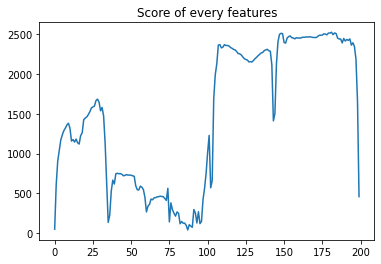

In [34]:
plt.plot(select_kbest.scores_)
plt.title("Score of every features")
plt.show()

In the case of the indiana hyperspectral image, it can be seen that features have different scores. Thus, features have different impacts for the classification. For instance, features between 50 and 100 are poorly relevant compared to the features between 100 and 200. However, the top scores are all close to each other. It does not seem to be relevant to use this feature extractor because we would select some features, but missing a lot of information by not using the other one.

## Classification API <a id="classification-api"></a>

[Table of content](#top-notebook)

In this section, a few functions are implemented for conveniency, factorization and cleaness of the code. Moreover, the usage of a sklearn classifier is the same no matter the classifier.

### Grid search with cross-validation<a id="grid-search"></a>
[Table of content](#top-notebook)

A classifier may have several hyperparameters. The goal is to find the best classifier with the best hyperparameters for a given problem. The grid search performs a exhaustive search over specified hyperparameters.

Workflow:
1. Create **classifier**
2. Create the list of **hyperparameters**
3. **Search** the best classifier (fit step). Try every combination of hyperparameters. For each combination, split the train data into 80% of **train data** and 20% of **validation data**. Fit with the train data. Score the classifier with the validation data. Repeat this 5 times for each combination until the whole data was covered by the validation data. Compute the mean score for each combination. Return the combination with the best score.
4. Compute the **score** of the classifier with the best hyperparameters over the test data.

documentation:
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">scikit-learn GridSearchCV</a>

In [108]:
from sklearn.model_selection import GridSearchCV

# / Positional argument before
# * Must name the parameter
def grid_search(clf, X, y, grid_params, /, *, n_jobs=-1, verbose=4):
    """
    Perform a grid search with cross validation
    
    Parameters
    ----------
    clf : classifier
        The classifier performing the grid search
    X: numpy.ndarray
        The input data
    y: numpy.ndarray
        The labels
    grid_params: dict
        The grid parameters. It must follow this syntax
        Key = step name from pipeline + __ + hyperparameter
        Value = tuple or list of possible values
        i.e. the name of the PCA classifier is pca:
        'pca__n_components': [1, 2, 5, 10]
    n_jobs: int, default=-1
        Number of jobs performing the grid search
    verbose: int, default=4
        Level of verbosity
        
    Returns
    -------
    dict
        Best parameters for the given classifier found by the search
    """
    
    # Create the gridsearch
    # Cross validation gridsearch
    gs = GridSearchCV(clf, grid_params, n_jobs=n_jobs, verbose=4)
    print("---- Start search ----")
    gs.fit(X, y)
    print("---- Search finished ----")
    print("Best parameter (CV score=%0.3f): " % gs.best_score_)
    print(gs.best_params_)
    return gs.best_params_

In the above function, the grid search is performed through a classifier. Scikit-learn gives a way to create a special kind of classifier called **Pipelines** (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">scikit-learn</a>). A pipeline consists of a sequence of transforms with a final estimator. The behavior is the same as a classifier but it also applied beforehand some transformation to the input data.

For instance, here is the workflow of a pipeline with a PCA (transform) then the classifier LinearSVC.

1. **Training**
    1. `PCA.fit(X_train)` --> fit the transform
    2. `Xproj = pca.transform(X_train)` --> transform the training input
    3. `LinearSVC.fit(Xproj, y_train)` --> fit the final estimator
2. **Test/Validation**
    1. `Xproj_test = pca.tranform(X_test)` --> transform the test input
    2. `LinearSVC.predict(X_proj_test, y_test)` --> predict the test input

The pipeline is very useful to not forget any steps of the transformation sequence. It is also very convenient to use.

### Evaluation <a id="api-evaluation"></a>
[Table of content](#top-notebook)


#### Confusion matrix
A confusion matrix usage is to evaluate the quality of the predictions of a classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The true labels are represented by the rows and the predictions by the columns.

Documentation:
 * scikit-learn documentation of confusion matrix <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html">here</a>.

In [36]:
from sklearn.metrics import confusion_matrix

def my_plot_confusion_matrix(conf_matrix, classes, title=None, figsize=(10,10)):
    """
    Plot the confusion matrix
    
    Parameters
    ----------
    conf_matrix : numpy.ndarray
        A computed confusion matrix
    classes: list
        Names of the categories/classes
    title: str, default=None
        Title of the plot
    figsize: tuple (int, int)
        Size of the figure
    """
    df_cm = pd.DataFrame(conf_matrix, classes, classes)
    plt.figure(figsize=figsize)
    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g', annot_kws={"size": 11}) # font size
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    if title:
        plt.title(title)
    else:
        plt.tile("Confusion matrix")
    ax.plot([1, 0], [0, 1], linewidth=0.2, color='black', transform=ax.transAxes)

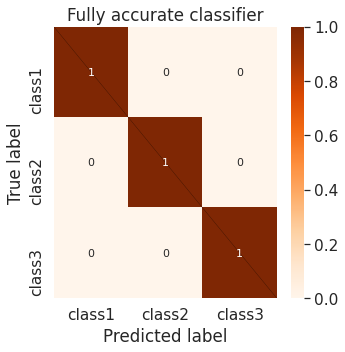

In [37]:
# Example of a confusion matrix
example_classes = ['class1', 'class2', 'class3']
example_val = np.identity(3)
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate classifier", figsize=(5,5))

In [38]:
from sklearn.metrics import classification_report

def my_classification_report(clf, X, y, shape, classes, clf_name=None):
    """
    Display a report of a given classifier for a labelled input
    
    Parameters
    ----------
    clf : classifier
        The classifier to report
    X: numpy.ndarray
        Data used for the report
    y: numpy.ndarray
        Labels of the data
    shape: tuple
        2D shape of the data
    classes: list
        Names of the categories/classes
    clf_name: str
        Name of the classifier
    """
    y_pred = clf.predict(X)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Plot confusion matrix
    title=None
    if clf_name:
        title = "Confusion matrix with " + clf_name + " classifier."
    my_plot_confusion_matrix(conf_matrix, classes, title)
    
    # Classification report
    print(classification_report(y, y_pred, target_names=classes))

#### Scores

The **accuracy** is computed this way: $$Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} $$



The **precision** for a class is the number of correctly predicted images of this class out of all predicted images of this class.

The **recall** for a class is the number of correctly predicted images of this class out of the number of actual images of this class.

The **f1-score** is the combination of the precision score and recall score such that $$\text{f1 score} = 2\frac{\text{precision}  \times \text{recall}}{\text{precision} + \text{recall}}$$ It tries to compromise the precision with the recall.

The f1-score can be computed in two different ways for more way of result interpretation:
* **macro**: Calculate metrics for each label and compute the unweighted mean. This does **not** take label imbalance into account
* **weighted**: Calculate metrics for each label and compute the average weighted by support (the number of true instances for each label).

The closer these scores get to 1, the more accurate the classifier is.

The blue rectangle represents the recall of class1
The green rectangle represents the precision of class1


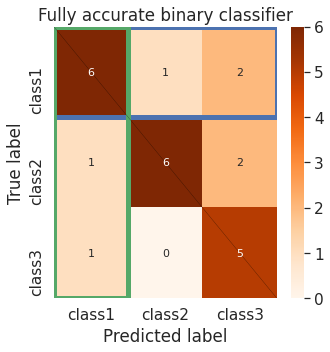

In [39]:
import matplotlib.patches as patches

# Display the recall and precision on a confusion matrix

example_val = np.array([[6, 1, 2], [1, 6, 2], [1, 0, 5]])
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate binary classifier", figsize=(5,5))
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(patches.Rectangle((0, 0), 3, 1, linewidth=5, edgecolor='b', facecolor='none'))
ax.add_patch(patches.Rectangle((0, 0), 1, 3, linewidth=5, edgecolor='g', facecolor='none'))
print("The blue rectangle represents the recall of class1")
print("The green rectangle represents the precision of class1")

In [57]:
from sklearn.metrics import f1_score

def evaluate_clf(clf, X_test, y_test):
    """
    Evaluate a classifier
    
    Compute and print the accuracy, f1 macro score and f1 weighted score
    of the classifier
    
    Parameters
    ----------
    clf : classifier
        The classifier to evaluate. The classifier must have already fit.
    X_test: numpy.ndarray
        Test data
    y_test: numpy.ndarray
        Labels of the test data
    """
    
    # Accuracy
    score = clf.score(X_test, y_test)
    
    # f1 macro
    y_pred = clf.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # f1 weighted
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Print scores
    print("Score: %0.3f." % score)
    print("f1 macro score: %0.3f." % f1_macro)
    print("f1 weighted score: %0.3f." % f1_weighted)
    
    return score, f1_macro, f1_weighted

## Multiclass classification<a id="multiclass-classification"></a>

[Table of content](#top-notebook)

TODO BLABLA Multiclass classification

Documentation:
* <a href="https://scikit-learn.org/stable/modules/multiclass.html">scikit-learn multi-class algorithms</a>

In [41]:
from sklearn.pipeline import Pipeline

### With other VS without other<a id="with-vs-without"></a>

[Table of content](#top-notebook)

In this section, the impact of the `other` category is checked. The data are strongly unbalanced especially with this category. As a reminder, this category means a lack of labelling. We want to avoid as much as possible bad accuracy because of it.

The checking will be processed this way:
1. Test classifiers accuracy **including** the `other` category
2. Test classifiers accuracy **excluding** the `other` category

The problem of the other category `other` can be found in every input (indiana and salinas). The verification is only performed with the indiana image. The result of this experience with any other image would be the same. Thus, it is not required to test over all the given images.

Separate the indiana data into two datasets. The first one includes the pixel labelled as `other`. The second one excludes them.

In [42]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_indiana, 
                                                                        y_indiana, 
                                                                        test_size=0.15,
                                                                        random_state=random_state)

X_train_with.shape, y_train_with.shape, X_test_with.shape, y_test_with.shape

((17871, 200), (17871,), (3154, 200), (3154,))

In [43]:
# Remove pixels with the unknown category (category 0)
X_indiana_without = X_indiana[np.where(y_indiana!=0)[0]]
y_indiana_without = y_indiana[np.where(y_indiana!=0)[0]]
X_indiana_without.shape, y_indiana_without.shape

((10249, 200), (10249,))

In [44]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X_indiana_without, 
                                                                                    y_indiana_without, 
                                                                                    test_size=0.15,
                                                                                    random_state=random_state)

X_train_without.shape, y_train_without.shape, X_test_without.shape, y_test_without.shape

((8711, 200), (8711,), (1538, 200), (1538,))

#### LinearSVC<a id="linear-svc-1"></a>

Let's proceed to the test using the **LinearSVC** classifier.

In [45]:
from sklearn.svm import LinearSVC

In [46]:
# Get the range of maximum of iterations for the LinearSVC
max_iter_range = [(i + 1) * 1000 for i in range(3)]
max_iter_range

[1000, 2000, 3000]

In [86]:
%%time
# With other
param_n_components = get_pca_components(X_train_with)

# Create pipe
pca = PCA(random_state=random_state)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state)

pipe_svc_with = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])
display(pipe_svc_with)

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'linearsvc__max_iter': max_iter_range,
}

# Search
best_params = grid_search(pipe_svc_with, X_train_with, y_train_with, grid_params)
print(best_params)

# Refit model with the best parameters
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state, max_iter=best_params['linearsvc__max_iter'])
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
pipe_svc_with = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])
pipe_svc_with.fit(X_train_with, y_train_with)

# Save
dump(pipe_svc_with, "models/pipe_svc_with.joblib")

# Score
score_svc_with = evaluate_clf(pipe_svc_with, X_test_with, y_test_with)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('linearsvc', LinearSVC(random_state=2727))])

---- Start search ----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


---- Search finished ----
Best parameter (CV score=0.443): 
{'linearsvc__max_iter': 2000, 'pca__n_components': 5}
{'linearsvc__max_iter': 2000, 'pca__n_components': 5}
Score: 0.363.
f1 macro score: 0.043.
f1 weighted score: 0.359.
CPU times: user 48.3 s, sys: 2.48 s, total: 50.8 s
Wall time: 11min 27s


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [87]:
%%time
# Without other
param_n_components = get_pca_components(X_train_without)

# Create pipe
pca = PCA(random_state=random_state)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state)

pipe_svc_without = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])
display(pipe_svc_without)

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'linearsvc__max_iter': max_iter_range,
}

# Search
best_params = grid_search(pipe_svc_without, X_train_without, y_train_without, grid_params)
print(best_params)


# Refit model without the best parameters
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state, max_iter=best_params['linearsvc__max_iter'])
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
pipe_svc_without = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])
display(pipe_svc_without)
pipe_svc_without.fit(X_train_without, y_train_without)

# Save
dump(pipe_svc_without, "models/pipe_svc_without.joblib")

# Score
score_svc_without = evaluate_clf(pipe_svc_without, X_test_without, y_test_without)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('linearsvc', LinearSVC(random_state=2727))])

---- Start search ----
Fitting 5 folds for each of 9 candidates, totalling 45 fits
---- Search finished ----
Best parameter (CV score=0.352): 
{'linearsvc__max_iter': 2000, 'pca__n_components': 22}
{'linearsvc__max_iter': 2000, 'pca__n_components': 22}


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('pca', PCA(n_components=22, random_state=2727)),
                ('linearsvc', LinearSVC(max_iter=2000, random_state=2727))])

Score: 0.357.
f1 macro score: 0.253.
f1 weighted score: 0.340.
CPU times: user 44.4 s, sys: 2.84 s, total: 47.2 s
Wall time: 3min 34s


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

                       Other       0.70      0.71      0.71      1595
                     Alfalfa       0.00      0.00      0.00         5
                 Corn-notill       0.00      0.00      0.00       208
                Corn-mintill       0.00      0.00      0.00       134
                        Corn       0.00      0.00      0.00        44
               Grass-pasture       0.00      0.06      0.01        86
                 Grass-trees       0.00      0.00      0.00       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.00      0.00      0.00        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.00      0.00      0.00       144
             Soybean-mintill       0.12      0.01      0.01       384
               Soybean-clean       0.00      0.00      0.00        91
                   

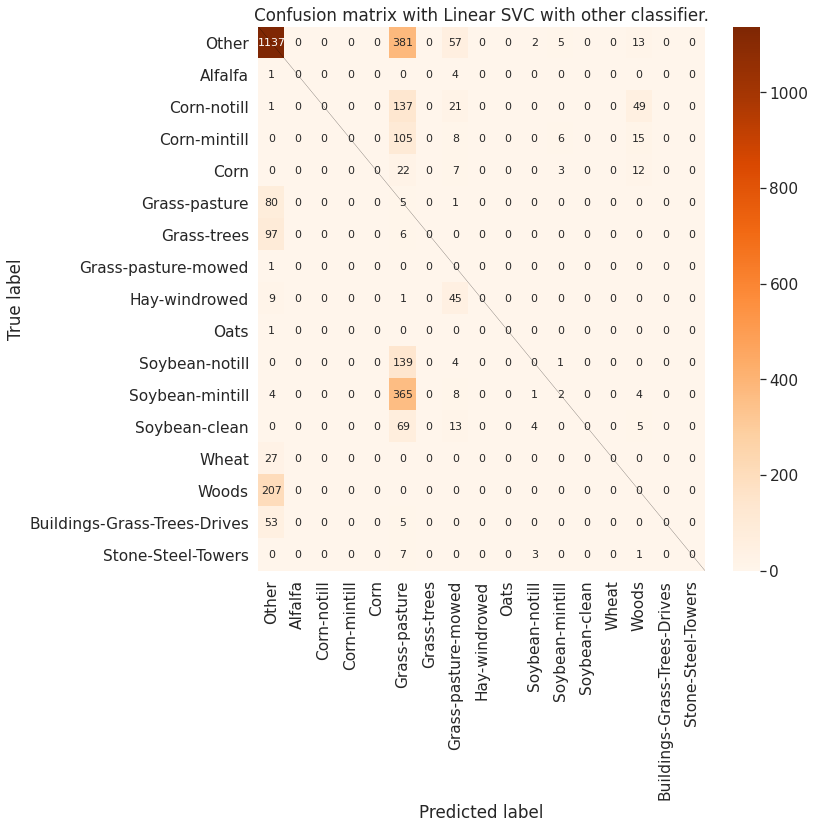

In [88]:
my_classification_report(pipe_svc_with,
                         X_test_with,
                         y_test_with,
                         (indiana_row, indiana_col),
                         label_to_category['indiana'].values(),
                         clf_name="Linear SVC with other")

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

                     Alfalfa       0.00      0.00      0.00         6
                 Corn-notill       0.00      0.00      0.00       223
                Corn-mintill       0.31      0.22      0.26       105
                        Corn       0.22      0.18      0.20        49
               Grass-pasture       0.00      0.00      0.00        69
                 Grass-trees       0.83      0.83      0.83       108
         Grass-pasture-mowed       0.00      0.00      0.00         7
               Hay-windrowed       0.72      0.88      0.79        67
                        Oats       0.00      0.00      0.00         4
              Soybean-notill       0.00      0.00      0.00       157
             Soybean-mintill       0.44      0.53      0.48       384
               Soybean-clean       0.00      0.00      0.00        74
                       Wheat       0.48      0.96      0.64        27
                   

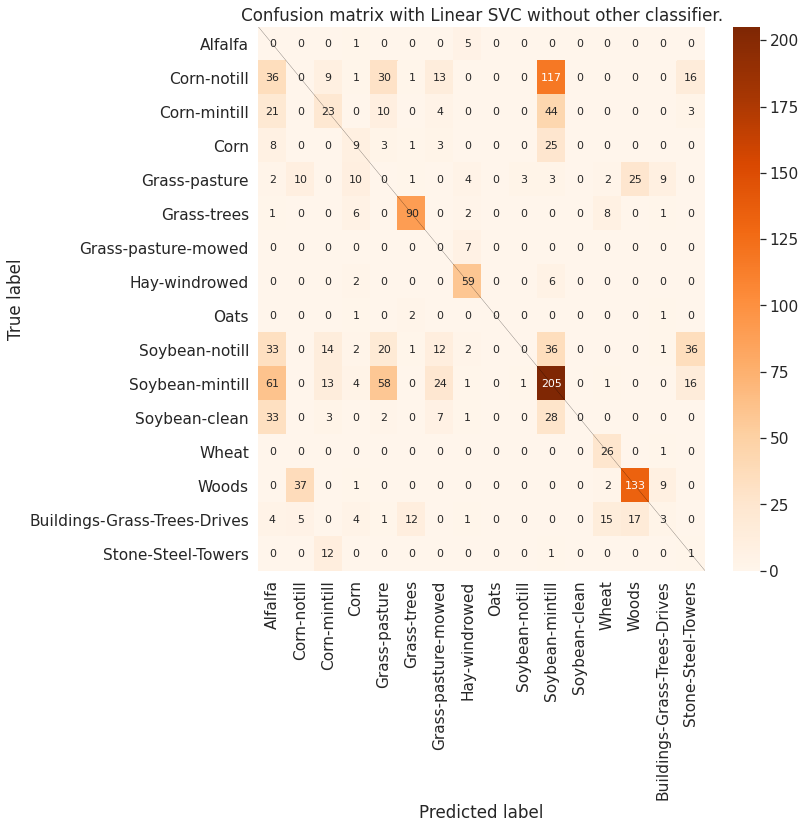

In [89]:
my_classification_report(pipe_svc_without,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         list(label_to_category['indiana'].values())[1:],
                         clf_name="Linear SVC without other")

#### RandomForest (Inherently multiclass)<a id="random_forest-1"></a>

Let's proceed to the test using the **RandomForest** classifier.

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
%%time
# With other
param_n_components = get_pca_components(X_train_with)

# Create pipe
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe_forest_with = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
display(pipe_forest_with)

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
    'random_forest__class_weight': ["balanced", "balanced_subsample", None]
}

# Search
best_params = grid_search(pipe_forest_with, X_train_with, y_train_with, grid_params, n_jobs=2)
print(best_params)

# Refit model with the best parameters
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(random_state=random_state,
                                           n_estimators=best_params['random_forest__n_estimators'],
                                           class_weight=best_params['random_forest__class_weight'])
pipe_forest_with = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
pipe_forest_with.fit(X_train_with, y_train_with)

# Save
dump(pipe_forest_with, "models/pipe_forest_with.joblib")

# Score
score_svc_with = evaluate_clf(pipe_forest_with, X_test_with, y_test_with)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('random_forest', RandomForestClassifier())])

2
---- Start search ----
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---- Search finished ----
Best parameter (CV score=0.778): 
{'pca__n_components': 25, 'random_forest__class_weight': None, 'random_forest__n_estimators': 1000}
{'pca__n_components': 25, 'random_forest__class_weight': None, 'random_forest__n_estimators': 1000}
Score: 0.783.
f1 macro score: 0.593.
f1 weighted score: 0.769.
CPU times: user 2min 48s, sys: 4.27 s, total: 2min 52s
Wall time: 58min 24s


In [110]:
%%time
# Without other
param_n_components = get_pca_components(X_train_without)

# Create pipe
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe_forest_without = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
display(pipe_forest_without)

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
    'random_forest__class_weight': ["balanced", "balanced_subsample", None]
}

# Search
best_params = grid_search(pipe_forest_without, X_train_without, y_train_without, grid_params, n_jobs=2)
print(best_params)

# Refit model without the best parameters
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(random_state=random_state,
                                           n_estimators=best_params['random_forest__n_estimators'],
                                           class_weight=best_params['random_forest__class_weight'])
pipe_forest_without = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
pipe_forest_without.fit(X_train_without, y_train_without)

# Save
dump(pipe_forest_without, "models/pipe_forest_without.joblib")

# Score
score_svc_without = evaluate_clf(pipe_forest_without, X_test_without, y_test_without)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('random_forest', RandomForestClassifier())])

2
---- Start search ----
Fitting 5 folds for each of 36 candidates, totalling 180 fits
---- Search finished ----
Best parameter (CV score=0.824): 
{'pca__n_components': 22, 'random_forest__class_weight': 'balanced', 'random_forest__n_estimators': 1000}
{'pca__n_components': 22, 'random_forest__class_weight': 'balanced', 'random_forest__n_estimators': 1000}
Score: 0.811.
f1 macro score: 0.783.
f1 weighted score: 0.805.
CPU times: user 1min 6s, sys: 3.37 s, total: 1min 10s
Wall time: 22min 14s


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

                       Other       0.79      0.90      0.84      1595
                     Alfalfa       1.00      0.40      0.57         5
                 Corn-notill       0.69      0.75      0.72       208
                Corn-mintill       0.86      0.56      0.68       134
                        Corn       0.65      0.25      0.36        44
               Grass-pasture       0.97      0.70      0.81        86
                 Grass-trees       0.89      0.62      0.73       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.89      0.98      0.93        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.71      0.77      0.74       144
             Soybean-mintill       0.78      0.83      0.80       384
               Soybean-clean       0.82      0.66      0.73        91
                   

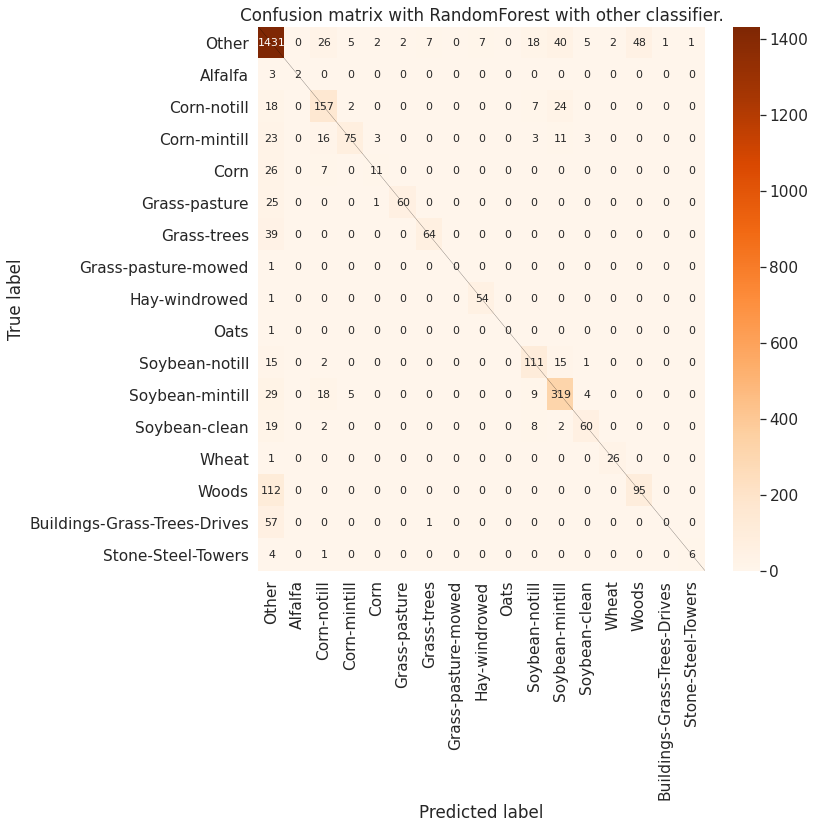

In [111]:
my_classification_report(pipe_forest_with,
                         X_test_with,
                         y_test_with,
                         (indiana_row, indiana_col),
                         label_to_category['indiana'].values(),
                         clf_name="RandomForest with other")

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.50      0.67         6
                 Corn-notill       0.72      0.71      0.72       223
                Corn-mintill       0.79      0.61      0.69       105
                        Corn       0.70      0.43      0.53        49
               Grass-pasture       0.97      0.86      0.91        69
                 Grass-trees       0.87      0.97      0.92       108
         Grass-pasture-mowed       1.00      0.86      0.92         7
               Hay-windrowed       0.93      1.00      0.96        67
                        Oats       1.00      0.25      0.40         4
              Soybean-notill       0.80      0.75      0.78       157
             Soybean-mintill       0.78      0.89      0.83       384
               Soybean-clean       0.73      0.70      0.72        74
                       Wheat       0.90      1.00      0.95        27
                   

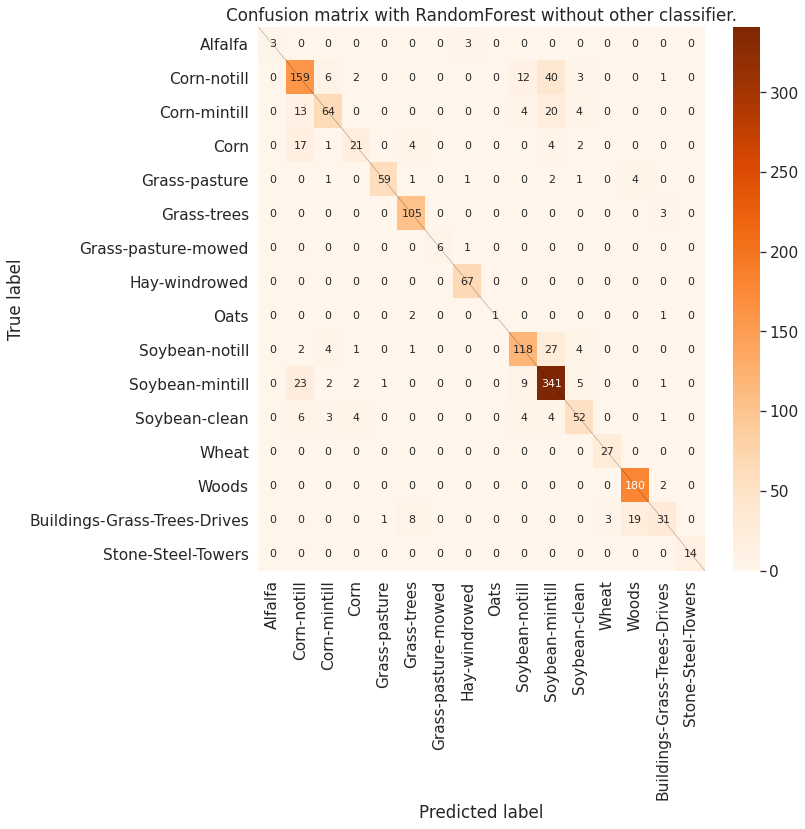

In [112]:
my_classification_report(pipe_forest_without,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         list(label_to_category['indiana'].values())[1:],
                         clf_name="RandomForest without other")

### Bench classifiers<a id="bench-classifier"></a>

[Table of content](#top-notebook)

#### LinearSVC (One Versus All)<a id="linear-svc-2"></a>

#### RandomForest (Inherently multiclass)<a id="random_forest-2"></a>

In [105]:
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier(random_state=random_state)
pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
    'random_forest__class_weight': ["balanced", "balanced_subsample", None]
}
print(pipe)
print(grid_params)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('random_forest', RandomForestClassifier(random_state=2727))])
{'pca__n_components': [2, 5, 25], 'random_forest__n_estimators': [1000], 'random_forest__class_weight': ['balanced', 'balanced_subsample', None]}


In [106]:
%%time
best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start search ----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---- Search finished ----
Best parameter (CV score=0.821): 
{'pca__n_components': 25, 'random_forest__class_weight': 'balanced_subsample', 'random_forest__n_estimators': 1000}
CPU times: user 48 s, sys: 2 s, total: 50 s
Wall time: 3min 55s


In [107]:
"""
{'pca__n_components': 25, 'random_forest__class_weight': 'balanced_subsample', 'random_forest__n_estimators': 1000}
"""
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(random_state=random_state,
                                           n_estimators=best_params['random_forest__n_estimators'],
                                           class_weight=best_params['random_forest__class_weight'])

pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe, X_train, y_train, X_test, y_test)

Score: 0.813.
f1 macro score: 0.791.
f1 weighted score: 0.807.


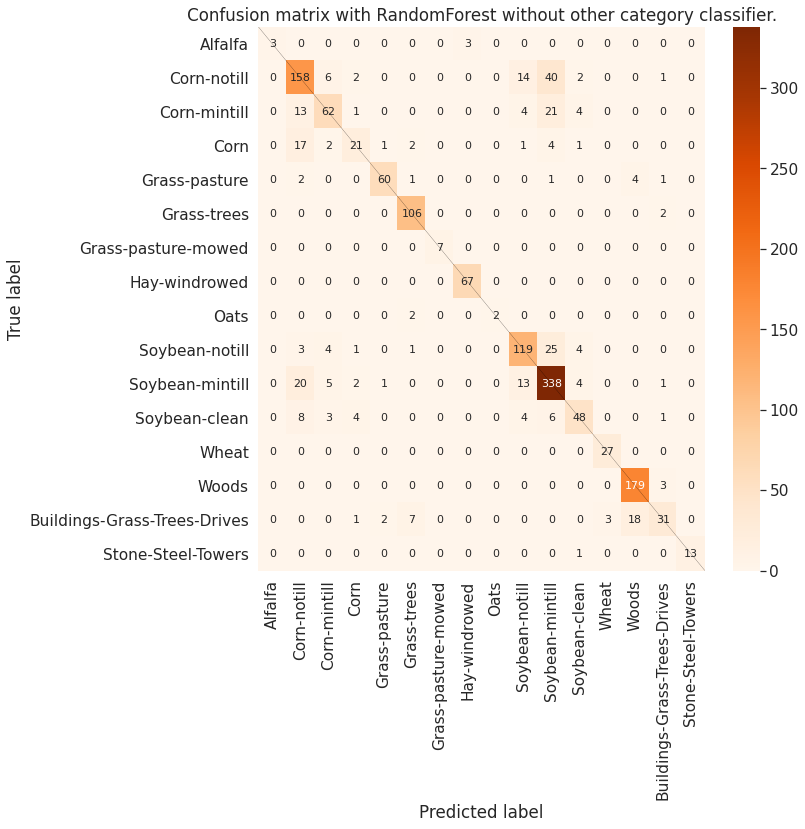

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.50      0.67         6
                 Corn-notill       0.71      0.71      0.71       223
                Corn-mintill       0.76      0.59      0.66       105
                        Corn       0.66      0.43      0.52        49
               Grass-pasture       0.94      0.87      0.90        69
                 Grass-trees       0.89      0.98      0.93       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       0.96      1.00      0.98        67
                        Oats       1.00      0.50      0.67         4
              Soybean-notill       0.77      0.76      0.76       157
             Soybean-mintill       0.78      0.88      0.83       384
               Soybean-clean       0.75      0.65      0.70        74
                       Wheat       0.90      1.00      0.95        27
                   

In [108]:
my_classification_report(pipe_random_forest, X_test, y_test, list(label_to_category.values())[1:], "RandomForest without other category")

#### K-nearest neighbors (Inherently multiclass)<a id="k-nearest-2"></a>

In [62]:
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(random_state=random_state)
k_neighbors_clf = KNeighborsClassifier()
pipe = Pipeline(steps=[('pca', pca), ('knn', k_neighbors_clf)])

grid_params = {
    'knn__n_neighbors' : [3,4,5,6,7],
    'knn__weights' : ['distance', 'uniform'],
    'knn__algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 30 , 50],
    'pca__n_components': param_n_components,
}
print(pipe)
print(grid_params)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('knn', KNeighborsClassifier())])
{'knn__n_neighbors': [3, 4, 5, 6, 7], 'knn__weights': ['distance', 'uniform'], 'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'], 'knn__leaf_size': [10, 30, 50], 'pca__n_components': [2, 5, 25]}


In [63]:
%%time
best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start search ----
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
---- Search finished ----
Best parameter (CV score=0.769): 
{'knn__algorithm': 'ball_tree', 'knn__leaf_size': 10, 'knn__n_neighbors': 4, 'knn__weights': 'distance', 'pca__n_components': 25}
CPU times: user 3.9 s, sys: 1.76 s, total: 5.66 s
Wall time: 1min 8s


In [64]:
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])

k_neighbors_clf = KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'],
                                       weights=best_params['knn__weights'],
                                       algorithm=best_params['knn__algorithm'],
                                       leaf_size=best_params['knn__leaf_size'])

pipe = Pipeline(steps=[('pca', pca), ('knn', k_neighbors_clf)])
evaluate_clf(pipe, X_train, y_train, X_test, y_test)

Score: 0.787.
f1 macro score: 0.783.
f1 weighted score: 0.783.


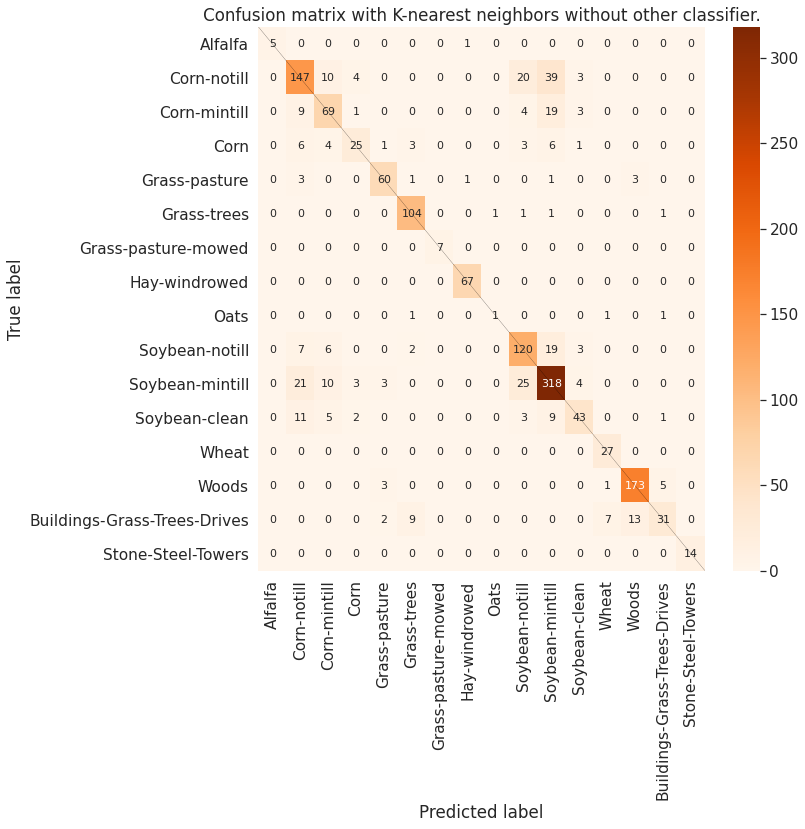

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.83      0.91         6
                 Corn-notill       0.72      0.66      0.69       223
                Corn-mintill       0.66      0.66      0.66       105
                        Corn       0.71      0.51      0.60        49
               Grass-pasture       0.87      0.87      0.87        69
                 Grass-trees       0.87      0.96      0.91       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       0.97      1.00      0.99        67
                        Oats       0.50      0.25      0.33         4
              Soybean-notill       0.68      0.76      0.72       157
             Soybean-mintill       0.77      0.83      0.80       384
               Soybean-clean       0.75      0.58      0.66        74
                       Wheat       0.75      1.00      0.86        27
                   

In [67]:
my_classification_report(pipe, X_test, y_test, list(label_to_category.values())[1:], "K-nearest neighbors without other")

#### SVC (One Versus One)<a id="svc-2"></a>

TODO


### Two consecutive classifiers<a id="two-consecutive-classifiers"></a>
[Table of content](#top-notebook)

In [54]:
y_train_bin = np.where(y_train==0, 0, 1).copy()
y_test_bin = np.where(y_test==0, 0, 1).copy()
X_train.shape, y_train_bin.shape, np.unique(y_train_bin)

((17871, 200), (17871,), array([0, 1]))

In [39]:
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe_bin = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
}

best_param = grid_search(pipe_bin, X_train, y_train_bin, grid_params)

NameError: name 'param_n_components' is not defined

In [55]:
#pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
#random_forest_clf = RandomForestClassifier(n_estimators=best_params['random_forest__n_estimators'])

pca = PCA(random_state=random_state, n_components=25)
random_forest_clf = RandomForestClassifier(n_estimators=3000)


pipe_bin = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe_bin, X_train, y_train_bin, X_test, y_test_bin)

Score: 0.831.
f1 macro score: 0.831.
f1 weighted score: 0.831.


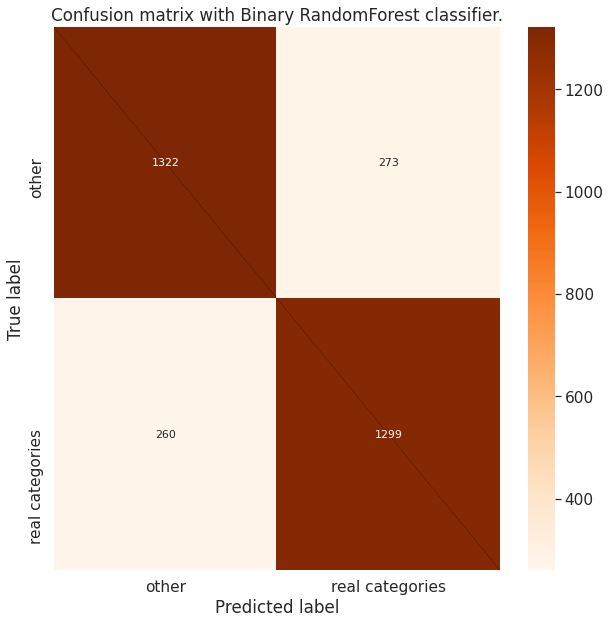

                 precision    recall  f1-score   support

          other       0.84      0.83      0.83      1595
real categories       0.83      0.83      0.83      1559

       accuracy                           0.83      3154
      macro avg       0.83      0.83      0.83      3154
   weighted avg       0.83      0.83      0.83      3154



In [56]:
my_classification_report(pipe_bin, X_test, y_test_bin, ["other", "real categories"], "Binary RandomForest")

In [57]:
res_bin = pipe_bin.predict(X_test)
res = []
for i in range(len(res_bin)):
    if res_bin[i] == 0:
        res.append(0)
    else:
        res.append(pipe_random_forest.predict(X_test[np.newaxis, i])[0])
res = np.array(res, dtype=np.uint8)

In [58]:
print(f1_score(y_test, res, average='macro'))
print(f1_score(y_test, res, average='weighted'))

0.6027956998282946
0.7592999357199787


## Evaluate best classifier<a id="evaluate-best-classifier"></a>

[Table of content](#top-notebook)

Evaluate X_indiana and the second image

y_pred = best_clf.predict(X_indiana)

score(y_indiana, y_pred)